In [1]:
%matplotlib widget
from helper import *
fk = ForwardKinematics()

<h1>Predictive Differential Kinematics</h1>

The goal of this chapter is to derive the differential model that has increased robustness to singularities. This increased robustness is realized by a predictive manipulability optimization that optimizes the manipulability of the cobot in **task direction**. For this first an new manipulability gradient is derived. After the gradient is derived, the QP problem introduced in the state of the art is extended to not only optimize the manipulability in task direction, but also take the joint position and joint velocity limits into account. To make sure the QP is feasible under all circumstances, a scaling $s$ is introduced, that scales the task velocity in case the tracking of the disired reference position is infeasible. Besides the theoretical foundations, the model is also setup in Python in parallel with the help of the OSQP optimization library <cite id="g1d7n"><a href="#zotero%7C16222978%2FPIMK7NG3">(Stellato et al., 2017)</a></cite>.

## Directional Manipulability Gradient

The manipulability measue $m(\theta)$ which was introduced by Yoshikawa <cite id="wp0tt"><a href="#zotero%7C16222978%2FB7SE9C3S">(Yoshikawa, 1985)</a></cite> gives a general metric to evaulate the manipulability of the manipulator. In singular configuration, when the jacobian degenerates and the cobot loses one or more degrees of freedom in the end-effector motion, the manipulability index is zero. 

In [2]:
def manipulability(q):
            
    J = fk.getBodyJacobian(q)

    return np.sqrt(max(0, np.linalg.det(J@J.T)))

# singular joint position 
q_example = [0,0,0,1.5708,0,0,0]
print("manipulability of example joint position: ", manipulability(q_example))

manipulability of example joint position:  0.0


The computation of the manipulability index is done with the body jacobian $J_b$. It expresses the cartesian end-effector velocities in the end-effector frame. This will later give an intuative way to compute apply the directionality feature to the gradient. To make use of the manipulability index, a gradient w.r.t the joint angles has to be computed. Practically this is often done via numerical differentiation as shown in the following code block. 

In [3]:
def manipulability_gradient(q):

    w0 = manipulability(q)
    h = 0.00001
    grad = []
    for i in range(fk.dof):
        q_temp = q.copy()
        q_temp[i] += h
        grad.append((manipulability(q_temp) - w0)/h)

    return np.array(grad)

# non singular joint position
q_example = [0,0,0,1.5708,0,0,0]

print("manipulability of example joint position: ", manipulability(q_example))
print("numerical manipulability gradient: ")
print(manipulability_gradient(q_example))

manipulability of example joint position:  0.0
numerical manipulability gradient: 
[   0.000    0.485    0.000    0.000    0.000    0.485    0.000]


An analytical approach is to compute the gradient via the manipulator hessian, this is a third order tensor that describes the second derivative of the forward kinematics w.r.t. the joint angles. it is closely related to the derivative of the jacobian w.r.t. time $\dot{J}$.

$$
\begin{align*}
\dot{J} &= \frac{d J(\theta)}{dt} \\
&= \frac{\partial J(\theta)}{\partial \theta} \frac{d\theta}{dt}\\
&= H(\theta) \dot{\theta}
\end{align*}
$$

where the manipulator hessian $H(\theta) \in \mathbb{R}^{6 \times DoF \times DoF}$ is a third order tensor. In practical applications it is often computed as the partial derviative of the chosen manipulator jacobian w.r.t. the joint angles. Haviland and Corke proposed a fast computation method which is applicable for the geometric Jacobian, but not the body or space jacobian. For this reason within this thesis we fall back to the numerical computation method of the hessian. Again it is based on the body jacobian for the easy and intuative application of the directional aspect later.

In [4]:
def getHessian(q):
    h = 0.000001
    J = fk.getBodyJacobian(q)

    # Initialize the Hessian tensor
    H = np.zeros((6, fk.dof, fk.dof))

    for i in range(fk.dof):
        q_temp = q.copy()
        q_temp[i] += h
        J_temp = fk.getBodyJacobian(q_temp)
        H[:, :, i] = (J_temp - J) / h

    return H

# non singular joint position
q_example = [0,0,0,2,0,1,2]

print("manipulator Hessian: ")
print(getHessian(q_example))

manipulator Hessian: 
[[[   0.000   -0.412    0.000   -0.412    0.827   -0.412    0.128]
  [   0.000    0.000    0.412   -0.000   -0.225    0.000   -0.416]
  [   0.000    0.000    0.000   -0.412    0.827   -0.412    0.128]
  [   0.000    0.000    0.000    0.000   -0.225   -0.000   -0.416]
  [   0.000    0.000    0.000    0.000    0.000    0.225    0.765]
  [   0.000    0.000    0.000    0.000    0.000    0.000   -0.416]
  [   0.000    0.000    0.000    0.000    0.000    0.000    0.000]]

 [[   0.000   -0.900    0.000   -0.900   -0.378   -0.900   -0.059]
  [   0.000    0.000    0.900   -0.000   -0.491   -0.000   -0.909]
  [   0.000    0.000    0.000   -0.900   -0.378   -0.900   -0.059]
  [   0.000    0.000    0.000    0.000   -0.491   -0.000   -0.909]
  [   0.000    0.000    0.000    0.000    0.000    0.491   -0.350]
  [   0.000    0.000    0.000    0.000    0.000    0.000   -0.909]
  [   0.000    0.000    0.000    0.000    0.000    0.000    0.000]]

 [[   0.000   -0.141   -0.000   -0.1

Following the derivaion of the manipulability gradient $J_m$ from (quelle) the hessian is used in combination with the body jacobian to have an analytical representation of the manipulability gradient which was just before computed numerically.

$$
J_m(\theta) = \sqrt{ \det \left( J(\theta)J(\theta)^T \right)}
\begin{bmatrix}
\text{vec}(J(\theta)H_1(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T)^{-1}) \\
\text{vec}(J(\theta)H_2(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T)^{-1}) \\
\vdots & \vdots \\
\text{vec}(J(\theta)H_{DoF}(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T)^{-1})
\end{bmatrix}
$$

is the manipulability Jacobian $J_m \in \mathbb{R}^{DoF}$ and where the matrix vector operation $\text{vec}(\cdot) : \mathbb{R}^{a \times b} \rightarrow \mathbb{R}^{ab}$ converts a matrix column-wise into a vector, and $H_i \in \mathbb{R}^{6 \times DoF}$ is the $i^{th}$ component of the manipulator Hessian tensor $H \in \mathbb{R}^{6 \times DoF \times DoF}$.

In [5]:
def analytic_manipulability_gradient(q):

    J = fk.getBodyJacobian(q)
    H = fk.getHessian(q)
    m = manipulability(q)

    b = np.linalg.inv(J@J.T)

    Jm = np.zeros(fk.dof)
    for i in range(fk.dof):
        c = J @ H[:,:,i].T
        Jm[i] = m*(c.flatten().T)@b.flatten()

    return Jm

# non singular joint position
q_example = [0,0,0,1.5708,0,0,0]

print("manipulator Hessian: ")
print(analytic_manipulability_gradient(q_example))

manipulator Hessian: 
[   0.000    0.000    0.000    0.000    0.000    0.000    0.000]


The manipulability gradient $J_m$ can later be used as gradient in the Quadratic programming problemn to maximize the manipulability of the manipulator.

$$
\dot{m} = J^T_m(q) \dot{q}
$$

as can be seen by moving the robot in a singular position, the gradient degenerates to zero in the analyticase, and moves in an usuitable direction in the numerical computation case. In bad cases. e.g. $q_4 = 0$, the inversion of $J(\theta)J(\theta)^T$ even becomes infeasible. To counter this undesirable behavior and to make sure that optimization is also possible in singular configuration, as well as to incoorperate the directional dependancy a new manipulability gradient is formulated.

$$
J_{dir}(\theta) = 
\begin{bmatrix}
\text{vec}(W_{dir} J(\theta)H_1(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T  + \lambda I)^{-1}) \\
\text{vec}(W_{dir} J(\theta)H_2(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T + \lambda I)^{-1}) \\
\vdots & \vdots \\
\text{vec}(W_{dir} J(\theta)H_{DoF}(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T + \lambda I)^{-1})
\end{bmatrix}
$$

Where the weighting matrix $W_{dir} \in \mathbb{R}^{6 \times 6}$ has the directional components of the desired task directions on its diagonal. The task directions matching to the body Jacobian and body Hessian $J_b(\theta)$ and $H_b(\theta)$ are defined in the end-effector frame, and can be written like this:

$$
 dir = \left( o_x, o_y, o_z, t_x, t_y, t_z \right)
$$

where $o$ describes the orientational directions and $t$ the translational directions.
The dampening factor $\lambda$ is chosen to be a small value that adequatly dampens the inversion of $J(\theta)J(\theta)^T$ so that the gradient is well defined at all times. 

In [6]:
def dir_manipulability_gradient(q, direction):

    J = fk.getBodyJacobian(q)
    H = fk.getHessian(q)
    W = np.diag(direction)

    b = np.linalg.inv(J@J.T + np.eye(6)*0.01)

    Jm = np.zeros(fk.dof)
    for i in range(fk.dof):
        c = W @ J @ H[:,:,i].T
        Jm[i] = (c.flatten().T)@b.flatten()

    return Jm


# non singular joint position
q_example = [0,0,0,np.pi*0.5,0,0,0]

direction = np.array([0,0,1, 0,0,0])


print(dir_manipulability_gradient(q_example, direction))

[   0.000    0.000    0.000    0.000    0.000   -0.000    0.000]


## Quadratic Program Formulation

The Quadratic program formulation used in this thesis differs from the common standard appraoch seen in most literature.The inverse differential kinematics problem will be formulated as closed loop and scalable IDK  to be sure that the problem is feasible at all times. If the problem is not scalable and the robot is in singular configurations it is often the case that the QP is not solvable. 
First, the standard OSQP <cite id="eig9g"><a href="#zotero%7C16222978%2FPIMK7NG3">(Stellato et al., 2017)</a></cite> formulation of a QP is shown: 

$$
\begin{align*}
\min_{x}& \; f(x) = \frac{1}{2} x^T P x + q^T x \\
\textrm{subject to}& \; l \leq Ax \leq u \\
\end{align*}
$$

Where $P$ is a positive semi-definit weighting matrix, $q$ is the gradient, $A$ is the constraint matrix and $l$ and $u$ are the lower and upper bounds respectively. The variables $x$ are the variables which are optimized during the optimization algorithm.
Besides that, instead of the standard twist or geometric jacobians the earlier introduced dual quaternioin jacobian $J_\mathbb{H}$ to follow the reference, which is given as the vectorized unit dual quaternion derivative $[\dot{\underline{\xi}}_{des}]_{vec}$. To incoorperate the time scaling, we extend the variable vector $x$, which consists of the joint velocities by the scaling factor $s$ and reformulate the constraint matrix $A$. 


$$
\begin{align*}
J_\mathbb{H}(\theta)\dot{\theta}  &= s[\dot{\underline{\xi}}_{des}]_{vec}\\
J_\mathbb{H}(\theta)\dot{\theta} - s[\dot{\underline{\xi}}_{des}]_{vec} &= 0 \\
\begin{bmatrix}
J_\mathbb{H}(\theta) & -[\dot{\underline{\xi}}_{des}]_{vec}\\
\end{bmatrix}
\begin{bmatrix}
\dot{\theta}\\
s
\end{bmatrix} &= 0 \\
Ax &= 0
\end{align*}
$$

Where $J_\mathbb{H}(\theta) \in \mathbb{R}^{8 \times DoF}$, $[\dot{\underline{\xi}}_{des}]_{vec} \in \mathbb{R}^{8 \times 1}$ and $s \in [0, 1]$.

The respective manipulability gradient can be set as the gradient in the minization function. Note that the sign is negative, as the manipulability should be maximized. Consideration of joint velocity, position and timescale boundaries is realized by the extension of the constraint matrix in the case of the joint velocity limits and the time scaling, and the formulation of a nonlinear joint position dependant gradient. The position limit gradient is the superposition of the common joint posiiton gradient which tries to minimize the joint angles of each joint $J_p = W_p \theta$ and the non-linear gradient which acts only in the vacinity of the joint position limit. This area is defined with a threshhold factor $u \in [0, 1]$ that defines a percentage of the joint range where the gradient applies. This gradient $J_l$ is defined per joint as follows:


$$
J_{l,i}(\theta_i) = \left\{ \begin{array}{cl}
\frac{ \theta_i - u \theta_{M_i}}{| \theta_{M_i} - \theta_i | + \lambda} & \theta_i \geq u \theta_{M_i} \\
\frac{\theta_i - u \theta_{m_i}}{|\theta_{m_i} - \theta_i | + \lambda} & \theta_i \leq u \theta_{m_i} \\
0 & \text{otherwise}
\end{array} \right.
$$

Where $\theta_i$ is the joint angle of the respective joint, $\theta_{M_i}$ is the maximum joint position of the $i^{th}$ joint and $\theta_{m_i}$ is the minumum joint angle respectively. With decreasing distance to the joint angles the gradient tends to a value of $\frac{(1-u)\theta_{M_i}}{\lambda}$, which can be arbitrary high depending on the choice of $\lambda$ and $u$. 

In [7]:
def velocity_damper(q, q_min, q_max):
    grad = np.zeros(fk.dof)

    thresh = 0.9
    for i in range(fk.dof):

        if q[i] > thresh*q_max[i]:
            grad[i] = (q[i] - thresh*q_max[i])/(abs(q[i] - q_max[i]) + 0.01)

        if q[i] < thresh*q_min[i]:
            grad[i] = (q[i] - thresh*q_min[i])/(abs(q[i] - q_min[i]) + 0.01)

    return grad

With the earlier introduced components and the extention with the time scale, the new QP formulation can be written as:

$$
\begin{align*}
\min_{x} \; f(x) = &\frac{1}{2} 
\begin{bmatrix}
\dot{\theta}\\
s
\end{bmatrix}^T 
\begin{bmatrix}
W_{\dot{\theta}} & 0\\
0 & \lambda_s
\end{bmatrix}
\begin{bmatrix}
\dot{\theta}\\
s
\end{bmatrix} + 
\begin{bmatrix}
(W_p \theta + \lambda_l J_l(\theta) - \lambda_{dir}J_{dir}(\theta, dir))\\
-2\lambda_s
\end{bmatrix}^T 
\begin{bmatrix}
\dot{\theta}\\
s
\end{bmatrix}\\
\\
\textrm{subject to}& \; 
\begin{bmatrix}
0_{DoF \times 1}\\
\dot{\theta}_m\\
0
\end{bmatrix} 
\leq 
\begin{bmatrix}
J_\mathbb{H}(\theta) & -[\dot{\underline{\xi}}_{des} + k_p\left(\underline{\xi}_{des} - fk(\theta)\right)]_{vec}\\
I_{DoF \times DoF} & 0_{DoF \times 1}\\
0_{1 \times DoF} & 1\\
\end{bmatrix} 
\begin{bmatrix}
\dot{\theta}\\
s
\end{bmatrix} \leq 
\begin{bmatrix}
0_{DoF \times 1}\\
\dot{\theta}_M\\
1
\end{bmatrix} 
\end{align*}
$$

Where the closed loop term $k_p\left(\underline{\xi}_{des} - fk(\theta)\right)$ was added to compensate any possible drift.

The predictive aspect of the controller is given by predictive describtion of the direction vector. Here, we evaluate the task in future timesteps and sum up the cartesian directions given by the dual quaternionic expression the computes the twist in the end-effector frame of the robot.

$$
dir_{pred}(t) = \frac{ dir_0 + 2 \sum_{i=0}^{n} \left| \left[ \underline{\xi}_{des}^*(t + i \Delta t)\otimes \underline{\dot{\xi}}_{des}(t + i \Delta t)\right]_{6vec}\right|}{ \left\| dir_0 + 2 \sum_{i=0}^{n} \left[ \underline{\xi}_{des}^*(t + i \Delta t)\otimes \underline{\dot{\xi}}_{des}(t + i \Delta t)\right]_{6vec}\right\|} 
$$

To cover the QP formulation in python code, the following code block will show the needed the matrices and the gradients. The full implementation can be found in the simulation folder which will be used in the following chapters.

In [8]:
from Simulation.QP_DifferentialKinematics import QP_DifferentialKinematics

idk = QP_DifferentialKinematics(verbose = True)

Weighting matrix P:
[[   5.500    0.000    0.000    0.000    0.000    0.000    0.000    0.000]
 [   0.000    5.500    0.000    0.000    0.000    0.000    0.000    0.000]
 [   0.000    0.000   11.000    0.000    0.000    0.000    0.000    0.000]
 [   0.000    0.000    0.000    0.550    0.000    0.000    0.000    0.000]
 [   0.000    0.000    0.000    0.000    0.550    0.000    0.000    0.000]
 [   0.000    0.000    0.000    0.000    0.000    0.550    0.000    0.000]
 [   0.000    0.000    0.000    0.000    0.000    0.000    0.550    0.000]
 [   0.000    0.000    0.000    0.000    0.000    0.000    0.000   35.000]]

Constraint matrix A (with placeholders for Jacobian and reference):
[[   2.000    2.000    2.000    2.000    2.000    2.000    2.000   -3.000]
 [   2.000    2.000    2.000    2.000    2.000    2.000    2.000   -3.000]
 [   2.000    2.000    2.000    2.000    2.000    2.000    2.000   -3.000]
 [   2.000    2.000    2.000    2.000    2.000    2.000    2.000   -3.000]
 [   2.000

Calling the constructor will print the respective matrices that are needed to setup the osqp QP problem. First the diagonal matrix $P$, which is weighting the minimization of the joint velocities and the error on the time scaling factor $s - 1 = 0$. Then the constraint matrix $A$ where the Jacobian $J_\mathbb{H}$ is replaced by a blockmatrix with constant value of 2, and the reference $[\dot{\underline{\xi}}_{des} + k_p\left(\underline{\xi}_{des} - fk(\theta)\right)]_{vec}$ which was replaced with constant values of $-3$ for easy visualization purposes.

The gradients which are used are not applied in the setup, only the value of $-2\lambda_s = -20$ can be seen. The constant lower and upper bounds show the joint velocity limits of $\dot{\theta}_i \in [-\frac{\pi}{2}, \frac{\pi}{2}]$ and $s \in [0,1]$.

During the task execution, the Jacobian $J_\mathbb{H}$, the reference $[\dot{\underline{\xi}}_{des} + k_p\left(\underline{\xi}_{des} - fk(\theta)\right)]_{vec}$, and the gradients will be updated based on the current joint position and task progression. The update functions that replace the respective blocks in the gradient and constraint matrix can be found in the <a href="./Simulation/QP_DifferentialKinematics.py">QP_DifferentialKinematics.py</a>.

In [9]:
%matplotlib widget
from helper import *
from Simulation.WaitTime import WaitTime
from Simulation.MoveJoint import MoveJoint
from Simulation.MoveLinear import MoveLinear
from Simulation.Simulation import Simulation
from Simulation.ForwardKinematics import ForwardKinematics
from neura_dual_quaternions import DualQuaternion, Quaternion

fk = ForwardKinematics()

q1 = np.array([deg2rad(20), deg2rad(0), deg2rad(-20), deg2rad(90), deg2rad(0), deg2rad(-90), deg2rad(0)])

quat0 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,1,0]))
quat1 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,0,1]))

x1 = DualQuaternion.fromQuatPos(quat0, np.array([0.350, 0, 1.138]))
x2 = DualQuaternion.fromQuatPos(quat0, np.array([0.815, 0, 1.138]))
x3 = DualQuaternion.fromQuatPos(quat1*quat0, np.array([0.815, 0, 1.138]))     

task_list = np.array([MoveJoint(q1, 2), MoveLinear(fk.getFK(q1), x1, 2), MoveLinear(x1, x2, 2), MoveLinear(x2, x3, 2), WaitTime(3)])

sim = Simulation(task_list, method = "qp")

sim.start()

As visible from the above example, the robot is capable to avoid singularity related velocity jumps and has robust, feasible solutions for the QP problem. The predictive direction computation allows the robot to self-optimize its configuration within the nullspace, without interference of the end-effector pose.

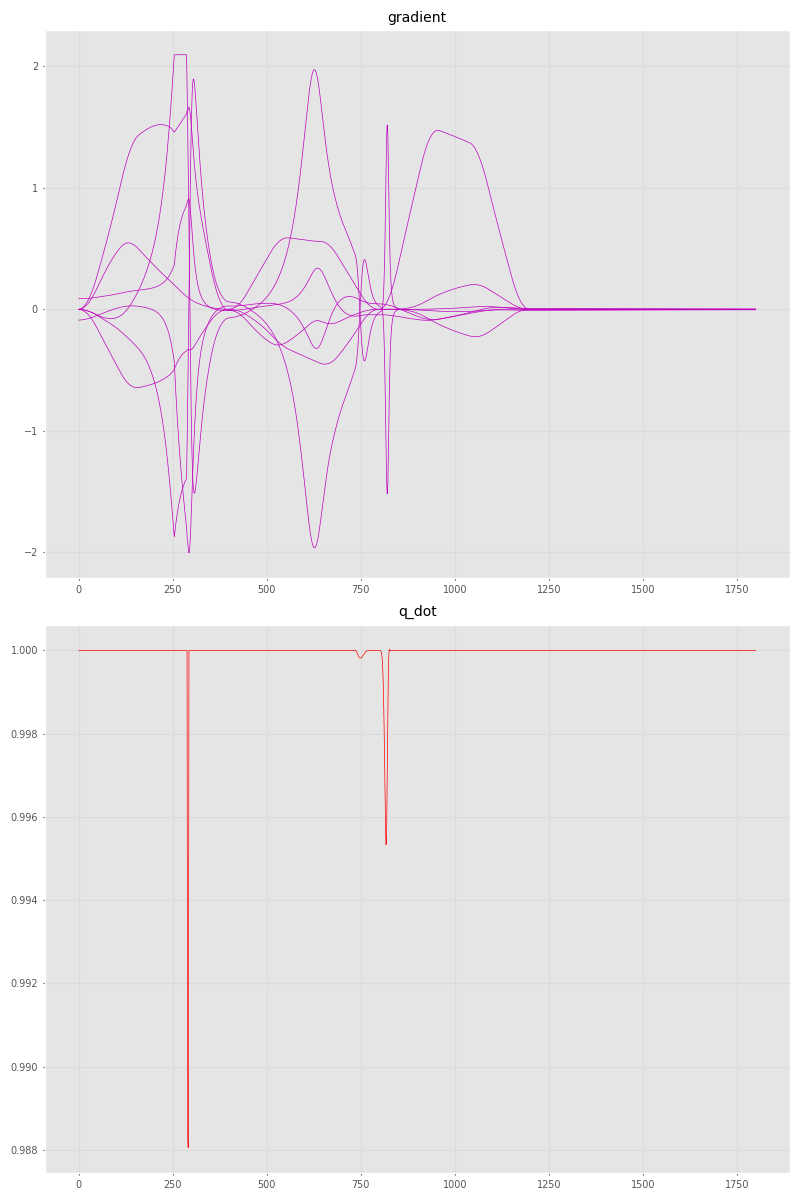

In [10]:
%matplotlib widget
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)

plt.plot(sim.q_dot_list, color = "m")
plt.title('gradient')

plt.subplot(2, 1, 2)

plt.plot(sim.time_scale_list, color = "r")
plt.title('q_dot')

# Show the plots
plt.tight_layout()
plt.show()
